In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Loading the dataset (Have Renamed "train.csv" to "Surprise_housing_assignment.csv")
data = pd.read_csv("Surprise_housing_assignment.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
#Shape
data.shape

(1460, 81)

In [4]:
# Feature Engineering

# Create a new feature 'TotalSF' by summing up all the square footage features
data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']

# Log-transform the 'SalePrice' to make it more normally distributed
data['SalePrice'] = np.log1p(data['SalePrice'])

In [5]:
# Log-transform skewed numerical features
numeric_feats = data.dtypes[data.dtypes != "object"].index
skewed_feats = data[numeric_feats].apply(lambda x: x.skew()).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skewed_feats})
skewness = skewness[abs(skewness) > 0.5]

In [6]:
# Display the skewness of numerical features before transformation
print("\nSkewness of Numerical Features (Before Transformation):")
print(skewness)


Skewness of Numerical Features (Before Transformation):
                    Skew
MiscVal        24.476794
PoolArea       14.828374
LotArea        12.207688
3SsnPorch      10.304342
LowQualFinSF    9.011341
KitchenAbvGr    4.488397
BsmtFinSF2      4.255261
ScreenPorch     4.122214
BsmtHalfBath    4.103403
EnclosedPorch   3.089872
MasVnrArea      2.669084
OpenPorchSF     2.364342
LotFrontage     2.163569
TotalSF         1.776700
BsmtFinSF1      1.685503
WoodDeckSF      1.541376
TotalBsmtSF     1.524255
MSSubClass      1.407657
1stFlrSF        1.376757
GrLivArea       1.366560
BsmtUnfSF       0.920268
2ndFlrSF        0.813030
OverallCond     0.693067
TotRmsAbvGrd    0.676341
HalfBath        0.675897
Fireplaces      0.649565
BsmtFullBath    0.596067
OverallQual          NaN
MoSold               NaN
BedroomAbvGr         NaN
GarageArea           NaN
SalePrice            NaN
YrSold               NaN
FullBath             NaN
Id                   NaN
GarageCars           NaN
YearRemodAdd   -0.

In [7]:
# Apply log transformation to skewed features
for feat in skewness.index:
    data[feat] = np.log1p(data[feat])

In [8]:
# One-hot encode categorical variables
data = pd.get_dummies(data)

In [9]:
data.shape

(1460, 290)

# Exploratory Data Analysis (EDA)

In [10]:
# Display basic statistics of numerical features
print("Basic Statistics of Numerical Features:")
print(data.describe())

Basic Statistics of Numerical Features:
                Id   MSSubClass  LotFrontage      LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000  1460.000000  1460.000000   
mean      6.294307     3.818794     4.207109     9.110966     1.940309   
std       0.975566     0.688354     0.346228     0.517369     0.201983   
min       0.693147     3.044522     3.091042     7.170888     0.693147   
25%       5.904680     3.044522     4.094345     8.929898     1.791759   
50%       6.595097     3.931826     4.248495     9.156887     1.945910   
75%       6.999650     4.262680     4.394449     9.358976     2.079442   
max       7.286876     5.252273     5.749393    12.279537     2.397895   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      1.869266     7.586821      7.593756     2.131946     4.229731  ...   
std       0.168400     0.015389      0.010424     2.6

In [11]:
# Display correlation matrix to identify relationships between numerical features
correlation_matrix = data.corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)


Correlation Matrix:
                             Id  MSSubClass  LotFrontage   LotArea  \
Id                     1.000000    0.033633    -0.031285 -0.024564   
MSSubClass             0.033633    1.000000    -0.430341 -0.378062   
LotFrontage           -0.031285   -0.430341     1.000000  0.744489   
LotArea               -0.024564   -0.378062     0.744489  1.000000   
OverallQual           -0.022213    0.090237     0.209063  0.166058   
...                         ...         ...          ...       ...   
SaleCondition_AdjLand -0.034930    0.030662    -0.036198 -0.013797   
SaleCondition_Alloca   0.003882    0.043334    -0.007318  0.016973   
SaleCondition_Family   0.014989    0.004400     0.009276 -0.004322   
SaleCondition_Normal   0.011240    0.033320    -0.064625 -0.018264   
SaleCondition_Partial -0.010867   -0.066732     0.119671  0.061604   

                       OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
Id                       -0.022213     0.009993  -0.013696    

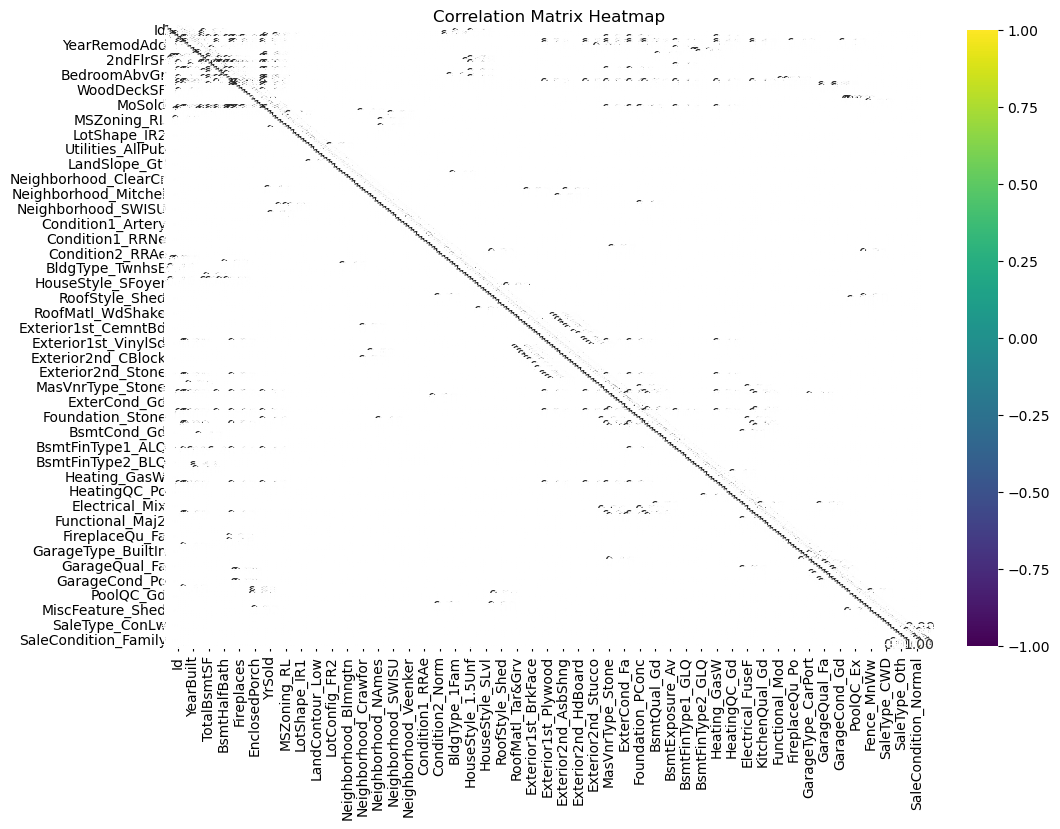

In [12]:
# Visualize correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="viridis", annot=True, fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

/Users/sammy/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


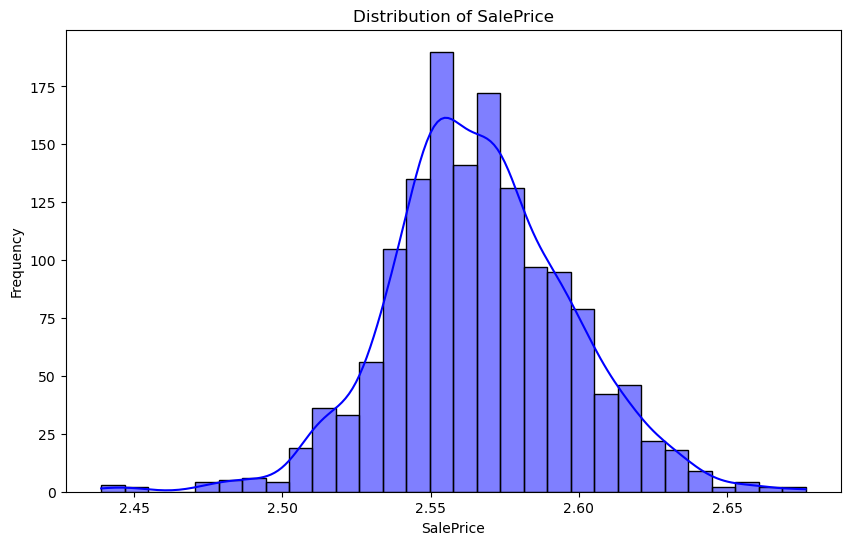

In [13]:
# Explore distribution of target variable 'SalePrice'
plt.figure(figsize=(10, 6))
sns.histplot(data['SalePrice'], bins=30, kde=True, color='blue')
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

Text(0.5, 1.0, 'Overall Quality vs. Sale Price')

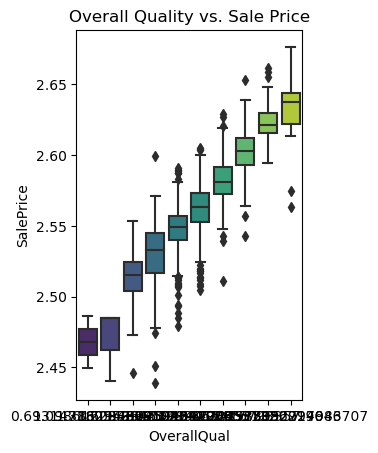

In [14]:
plt.subplot(1, 2, 1)
sns.boxplot(x='OverallQual', y='SalePrice', data=data, palette='viridis')
plt.title("Overall Quality vs. Sale Price")

Text(0.5, 1.0, 'Living Area vs. Sale Price')

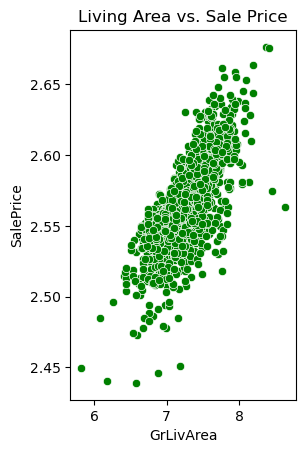

In [15]:
plt.subplot(1, 2, 2)
sns.scatterplot(x='GrLivArea', y='SalePrice', data=data, color='green')
plt.title("Living Area vs. Sale Price")

In [16]:
# Split the dataset into training and testing sets
X = data.drop("SalePrice", axis=1)
y = data["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Impute missing values in the dataset (replace NaN with the median)
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

<IPython.core.display.Javascript object>

In [18]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [19]:
# Build Ridge Regression Model
ridge = Ridge()

In [20]:
# Perform hyperparameter tuning for Ridge
ridge_parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
ridge_grid = GridSearchCV(Ridge(), ridge_parameters, scoring='neg_mean_squared_error', cv=5)
ridge_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='neg_mean_squared_error')

In [21]:
# Get the best alpha for Ridge
ridge_best_alpha = ridge_grid.best_params_['alpha']

In [22]:
# Train Ridge Regression with the best alpha
ridge_regressor = Ridge(alpha=ridge_best_alpha)
ridge_regressor.fit(X_train_scaled, y_train)

Ridge(alpha=100)

In [23]:
# Perform hyperparameter tuning for LASSO
lasso_parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
lasso_grid = GridSearchCV(Lasso(), lasso_parameters, scoring='neg_mean_squared_error', cv=5)
lasso_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='neg_mean_squared_error')

In [24]:
# Get the best alpha for LASSO
lasso_best_alpha = lasso_grid.best_params_['alpha']

In [25]:
# Feature Selection with LASSO
lasso_regressor = Lasso(alpha=lasso_best_alpha)
lasso_regressor.fit(X_train_scaled, y_train)

Lasso(alpha=0.001)

In [26]:
# Select features using non-zero coefficients from LASSO
selected_features = X_train.columns[lasso_regressor.coef_ != 0]

In [27]:
print(type(selected_features))
print(selected_features)

<class 'pandas.core.indexes.base.Index'>
Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'BsmtFinSF1', 'GrLivArea', 'BsmtFullBath', 'KitchenAbvGr', 'Fireplaces',
       'GarageCars', 'WoodDeckSF', 'TotalSF', 'MSZoning_C (all)',
       'MSZoning_RM', 'Neighborhood_Crawfor', 'Neighborhood_Edwards',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_StoneBr',
       'Condition1_Artery', 'Condition1_Norm', 'Condition2_PosN',
       'RoofMatl_ClyTile', 'Exterior1st_BrkFace', 'ExterQual_TA',
       'Foundation_PConc', 'BsmtQual_Ex', 'BsmtQual_TA', 'BsmtCond_Fa',
       'BsmtExposure_Gd', 'BsmtExposure_No', 'BsmtFinType1_GLQ',
       'Heating_Grav', 'HeatingQC_Ex', 'CentralAir_N', 'CentralAir_Y',
       'KitchenQual_Ex', 'KitchenQual_TA', 'Functional_Maj2', 'Functional_Typ',
       'SaleCondition_Abnorml', 'SaleCondition_Partial'],
      dtype='object')


In [28]:
# Get the column indices for selected features
selected_feature_indices = [X_train.columns.get_loc(feature) for feature in selected_features]

# Apply feature selection to the test set
X_test_selected = X_test_scaled[:, selected_feature_indices]

In [29]:
# Ridge Regression with selected features
ridge_final = Ridge(alpha=ridge_best_alpha)
ridge_final.fit(X_train_scaled[:, selected_feature_indices], y_train)

Ridge(alpha=100)

In [30]:
# Predictions
y_pred_ridge = ridge_final.predict(X_test_selected)

In [31]:
# Evaluate the model
ridge_mse = mean_squared_error(y_test, y_pred_ridge)
print(f'Ridge Regression Mean Squared Error: {ridge_mse}')

Ridge Regression Mean Squared Error: 9.28522028105148e-05


In [32]:
# Apply feature selection to the test set
X_test_selected = X_test_scaled[:, selected_feature_indices]

In [33]:
# Lasso Regression with selected features
lasso_final = Lasso(alpha=lasso_best_alpha)
lasso_final.fit(X_train_scaled[:, selected_feature_indices], y_train)

Lasso(alpha=0.001)

In [34]:
# Predictions
y_pred_lasso = lasso_final.predict(X_test_selected)

In [35]:
# Evaluate the model
lasso_mse = mean_squared_error(y_test, y_pred_lasso)
print(f'Lasso Regression Mean Squared Error: {lasso_mse}')

Lasso Regression Mean Squared Error: 0.00011682401210143753


In [36]:
# Evaluate performance
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

In [37]:
print("Ridge Regression RMSE on Test Set:", ridge_rmse)
print("LASSO Regression RMSE on Test Set:", lasso_rmse)

Ridge Regression RMSE on Test Set: 0.009635984786751938
LASSO Regression RMSE on Test Set: 0.01080851572147802


In [38]:
# Accuracy for Lasso
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f'Mean Squared Error (Lasso): {mse_lasso}')
print(f'R-squared (Lasso): {r2_lasso}')

Mean Squared Error (Lasso): 0.00011682401210143753
R-squared (Lasso): 0.8941338471416778


In [39]:
# Accuracy for Ridge
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f'Mean Squared Error (Ridge): {mse_ridge}')
print(f'R-squared (Ridge): {r2_ridge}')

Mean Squared Error (Ridge): 9.28522028105148e-05
R-squared (Ridge): 0.9158571485506365
